# Extracting Canopy Height and Elevation from LiDAR Based Global Ecosystem Dynamics Investigation (GEDI)

This Python Notebook utilizes the GEDI L2A V001 from May 2020 (before California's catastrophic wildfire events of summer 2020) covering the August Complex Fire from Northern California. The script will show you how to employ Python 3.8 to:
> - Find granules that contain data within the users's region of interest (ROI) using GEDI Finder tool
> - Acquire the user selected granules using Curl in Mac using NASA Earthdata login credentials
> - Read and process the dataset
> - Filter the dataset by ROI, quality of observations, and Science Dataset (SDS) Layers
> - Visualize the spatial footprint of the GEDI using representative observations 
> - Visualize Canopy Height and Elevation for the single day from May 2020
> - Converting the Geopandas GeoDataFrame to Google Earth Engine (GEE) Feature Collections
> - Export the Feature Collections to the Asset in GEE for further analysis

The GEDI instrument aboard the International Space Station (ISS) collects light detection and ranging (LiDAR) full waveform observations (https://lpdaac.usgs.gov/documents/635/GEDI_Quick_Guide.pdf). GEDI has been optimized to provide global measures of **vegetation structure**. The footprint is large enough to measure whole trees while being small enough to accurately detect the ground on steep terrain. GEDI measurements penetrate **dense canopies** and provide comprehensive sampling (https://gedi.umd.edu/instrument/specifications/).

## Finding Exact Granules using GEDI Finder Service
(https://lpdaac.usgs.gov/documents/591/GEDIFinder_UserGuide_v1.0.pdf)

This service accepts four parameters (product, version, bbox, and output) to identify the granules that intersect the region of interest (ROI). For my ROI, the following GEDI Finder service URL was prepared:

**https://lpdaacsvc.cr.usgs.gov/services/gedifinder?product=GEDI02_A&version=001&bbox=40.871987756697415,-124.486083984375,38.38472766885085,-120.9649658203125&output=html**

where
> - GEDI02_A: represents product short names for each GEDI data product
> - 001: represents the version of the GEDI data product
> - 40.871987756697415,-124.486083984375,38.38472766885085,-120.9649658203125: represents the bounding box of ROI
> - html: represents the required output format 

The URL link created above was then added to a web browser and it returns the URLs ready for download. From the returned URL links, six items from May 2020 were selected for further analysis, which are given below:

https://e4ftl01.cr.usgs.gov/GEDI/GEDI02_A.001/2020.05.01/GEDI02_A_2020122102750_O07845_T01609_02_001_01.h5
https://e4ftl01.cr.usgs.gov/GEDI/GEDI02_A.001/2020.05.02/GEDI02_A_2020123094103_O07860_T00859_02_001_01.h5
https://e4ftl01.cr.usgs.gov/GEDI/GEDI02_A.001/2020.05.05/GEDI02_A_2020126085335_O07906_T03032_02_001_01.h5
https://e4ftl01.cr.usgs.gov/GEDI/GEDI02_A.001/2020.05.09/GEDI02_A_2020130071919_O07967_T03185_02_001_01.h5
https://e4ftl01.cr.usgs.gov/GEDI/GEDI02_A.001/2020.05.22/GEDI02_A_2020143080101_O08169_T04321_02_001_01.h5
https://e4ftl01.cr.usgs.gov/GEDI/GEDI02_A.001/2020.05.25/GEDI02_A_2020146010156_O08211_T02527_02_001_01.h5

Then, the above six GEDI Finder service returned URL links were downloaded using **Curl Command-Line Tool** through automate approach.

**<font color='red'>Remember :</font>** the average file size of GEDI02_A data products is around **6.5 GB**

## Required Packages

In [1]:
import os
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gp
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import folium
from glob import glob
from datetime import datetime
import ee
import geemap #Earth Engine Python API and interactive mapping
import time

## Reading, Processing, and Filtering the GEDI Observations

The function given below (gediHeight)takes two user defined inputs, the **file name of the GEDI data product** and **the file name of the bounding box**.

In [2]:
def gediHeight(filename_single,filaname_geojson):
    
    gediL2A = h5py.File(filename_single, 'r')
    beamNames = [g for g in gediL2A.keys() if g.startswith('BEAM')]
    gediL2A_objs = []
    gediL2A.visit(gediL2A_objs.append)                                           # Retrieve list of datasets
    gediSDS = [o for o in gediL2A_objs if isinstance(gediL2A[o], h5py.Dataset)]  # Search for relevant SDS inside data file
    
    # Set up lists to store data
    shotNum, dem, zElevation, zHigh, zLat, zLon, rh25, rh98, rh100 ,quality ,degrade, sensitivity ,beamI = ([] for i in range(13))  
    
    # Loop through each beam and open the SDS needed
    for b in beamNames:
        [shotNum.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()]]
        [dem.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/digital_elevation_model') and b in g][0]][()]]
        [zElevation.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/elev_lowestmode') and b in g][0]][()]]  
        [zHigh.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/elev_highestreturn') and b in g][0]][()]]  
        [zLat.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/lat_lowestmode') and b in g][0]][()]]  
        [zLon.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/lon_lowestmode') and b in g][0]][()]]  
        [rh25.append(h[25]) for h in gediL2A[[g for g in gediSDS if g.endswith('/rh') and b in g][0]][()]]  
        [rh98.append(h[98]) for h in gediL2A[[g for g in gediSDS if g.endswith('/rh') and b in g][0]][()]]
        [rh100.append(h[100]) for h in gediL2A[[g for g in gediSDS if g.endswith('/rh') and b in g][0]][()]]  
        [quality.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/quality_flag') and b in g][0]][()]]  
        [degrade.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/degrade_flag') and b in g][0]][()]]  
        [sensitivity.append(h) for h in gediL2A[[g for g in gediSDS if g.endswith('/sensitivity') and b in g][0]][()]]  
        [beamI.append(h) for h in [b] * len(gediL2A[[g for g in gediSDS if g.endswith('/shot_number') and b in g][0]][()])]  
   
    ## This function convert "yyyyjjjhhmmss" to datetime 
    def julTodatetime(julianFormat):
        yyyyjjjhhmmss = filename_single[(filename_single.find('GEDI02_A_')+len('GEDI02_A_')):(filename_single.find('T0')-8)]
        yyyyjjj = yyyyjjjhhmmss[:7]
        hhmmss = yyyyjjjhhmmss[7:]
        yyyymmdd = str(datetime.strftime((datetime.strptime(yyyyjjj, '%Y%j')), '%Y-%m-%d'))
        datestd = datetime.strptime(yyyymmdd + hhmmss,'%Y-%m-%d%H%M%S')
        return datestd, yyyymmdd
    
    date_time, yyyymmdd = julTodatetime(filename_single)
    
    #The rh dataset stores the relative height metrics at 1% intervals, and thus each shot contains 101 values representing rh at 0-100%.
            
    # Convert lists to Pandas dataframe
    allDF = pd.DataFrame({'Acquisition Date_Time': [date_time] * len(shotNum),'Shot Number': shotNum, 'Beam': beamI, 'Latitude': zLat, 'Longitude': zLon, 'Tandem-X DEM': dem,
                         'Elevation (m)': zElevation, 'Canopy Elevation (m)': zHigh, 'Canopy Height (rh100)': rh100, 'RH 98': rh98,
                         'RH 25': rh25, 'Quality Flag': quality, 'Degrade Flag': degrade, 'Sensitivity': sensitivity})
    
    #del gediL2A, beamI, degrade, dem, gediSDS, rh100, rh98, rh25, quality, sensitivity, zElevation, zHigh, zLat, zLon, shotNum
    
    # Reading geojson file as geopandas
    gp_geojson = gp.read_file("./data_Northern_CA/August_Complex_Zoomed_Out_Oct_5_2020.geojson")
    bbox_extent = gp_geojson.total_bounds
    left_box, bottom_box, right_box, top_box = bbox_extent 
    lon_center, lat_center = np.array(bbox_extent).reshape(2, 2).mean(axis=0)
    
    # Filter by the bounding box 
    allDF_Filtered_ROI = allDF[(allDF['Latitude']>bottom_box)&(allDF['Latitude']<top_box)&(allDF['Longitude'] > left_box)&(allDF['Longitude'] < right_box)]
    del allDF
    
    # Filter out any poor quality shots that exist within the ROI & Set any poor quality returns to NaN
    allDF_Filtered_ROI_Quality = allDF_Filtered_ROI[(allDF_Filtered_ROI['Quality Flag'].ne(0))&(allDF_Filtered_ROI['Degrade Flag'].ne(1))\
                                                    &(allDF_Filtered_ROI['Sensitivity'] > 0.95)].dropna().reset_index()#drop=True
    allDF_Filtered_ROI_Quality = allDF_Filtered_ROI_Quality.rename(columns={'index': 'Shot Index'})
    del allDF_Filtered_ROI
    
    # Take the lat/lon dataframe and convert each lat/lon to a shapely point
    gdf = gp.GeoDataFrame(allDF_Filtered_ROI_Quality, geometry=gp.points_from_xy(allDF_Filtered_ROI_Quality.Longitude, allDF_Filtered_ROI_Quality.Latitude))
    #gdf = gdf.drop(columns=['Latitude','Longitude'])
    del allDF_Filtered_ROI_Quality
    
    return gdf, lon_center, lat_center, yyyymmdd

### Listing and sorting the GEDI data products and Geojson file covering ROI

In [3]:
filenames_combined = sorted(glob("./data_Northern_CA/GEDI*.h5"))
filenames_combined

['./data_Northern_CA/GEDI02_A_2020122102750_O07845_T01609_02_001_01.h5',
 './data_Northern_CA/GEDI02_A_2020123094103_O07860_T00859_02_001_01.h5',
 './data_Northern_CA/GEDI02_A_2020126085335_O07906_T03032_02_001_01.h5',
 './data_Northern_CA/GEDI02_A_2020130071919_O07967_T03185_02_001_01.h5',
 './data_Northern_CA/GEDI02_A_2020143080101_O08169_T04321_02_001_01.h5',
 './data_Northern_CA/GEDI02_A_2020146010156_O08211_T02527_02_001_01.h5']

In [4]:
filaname_geojson = glob("./data_Northern_CA/*.geojson")
filaname_geojson

['./data_Northern_CA/August_Complex_Zoomed_Out_Oct_5_2020.geojson']

### Calling the function "gediHeight" for the file names of GEDI data product and ROI

In [5]:
gdf, lon_center, lat_center, yyyymmdd = gediHeight(filenames_combined[0],filaname_geojson)

In [6]:
# Print information about a DataFrame 
gdf.info()

# Check if the colunms contain NAN
print('Checking NAN: {}'.format(gdf.isna().sum()))

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 7104 entries, 0 to 7103
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Shot Index             7104 non-null   int64         
 1   Acquisition Date_Time  7104 non-null   datetime64[ns]
 2   Shot Number            7104 non-null   int64         
 3   Beam                   7104 non-null   object        
 4   Latitude               7104 non-null   float64       
 5   Longitude              7104 non-null   float64       
 6   Tandem-X DEM           7104 non-null   float32       
 7   Elevation (m)          7104 non-null   float32       
 8   Canopy Elevation (m)   7104 non-null   float32       
 9   Canopy Height (rh100)  7104 non-null   float32       
 10  RH 98                  7104 non-null   float32       
 11  RH 25                  7104 non-null   float32       
 12  Quality Flag           7104 non-null   int8          


## Visualizing the Spatial Footprint of the GEDI Data Product using Representative Observations

In [7]:
# Extracting locations (longitude and latitude) for mapping
locations = gdf.iloc[:,4:6]
locationlist = locations.values.tolist()

my_map = folium.Map(location=[lat_center, lon_center],tiles='Stamen Terrain', zoom_start=8)

for i in range(0, len(locationlist)):
    if i % 100 == 0: # Take every 100th      
        my_string = '- Beam: {}, - Canopy Height (m): {}, - Elevation (m): {}'.format(gdf['Beam'][i], gdf['Canopy Height (rh100)'][i],\
                                                        gdf['Elevation (m)'][i])
        folium.Marker(locationlist[i], popup=my_string,fill_color='blue', radius=1).add_to(my_map)
    
folium.GeoJson(
    './data_Northern_CA/August_Complex_Zoomed_Out_Oct_5_2020.geojson',
    name='Limpopo River Basin',
    style_function=lambda feature: {
        'fillColor': 'None',
        'color' : 'blue',
        'weight' : 3,
    }
).add_to(my_map)
my_map 

#### Below is a screenshot of the ROI:

![alt text](./data_Northern_CA/GEDI_L2A_Northern_CA_Zoomed_In.png "Representative of GEDI L1A")

## Spatial Visualization of Canopy Height and Elevation of All Available Beams for Specific Date

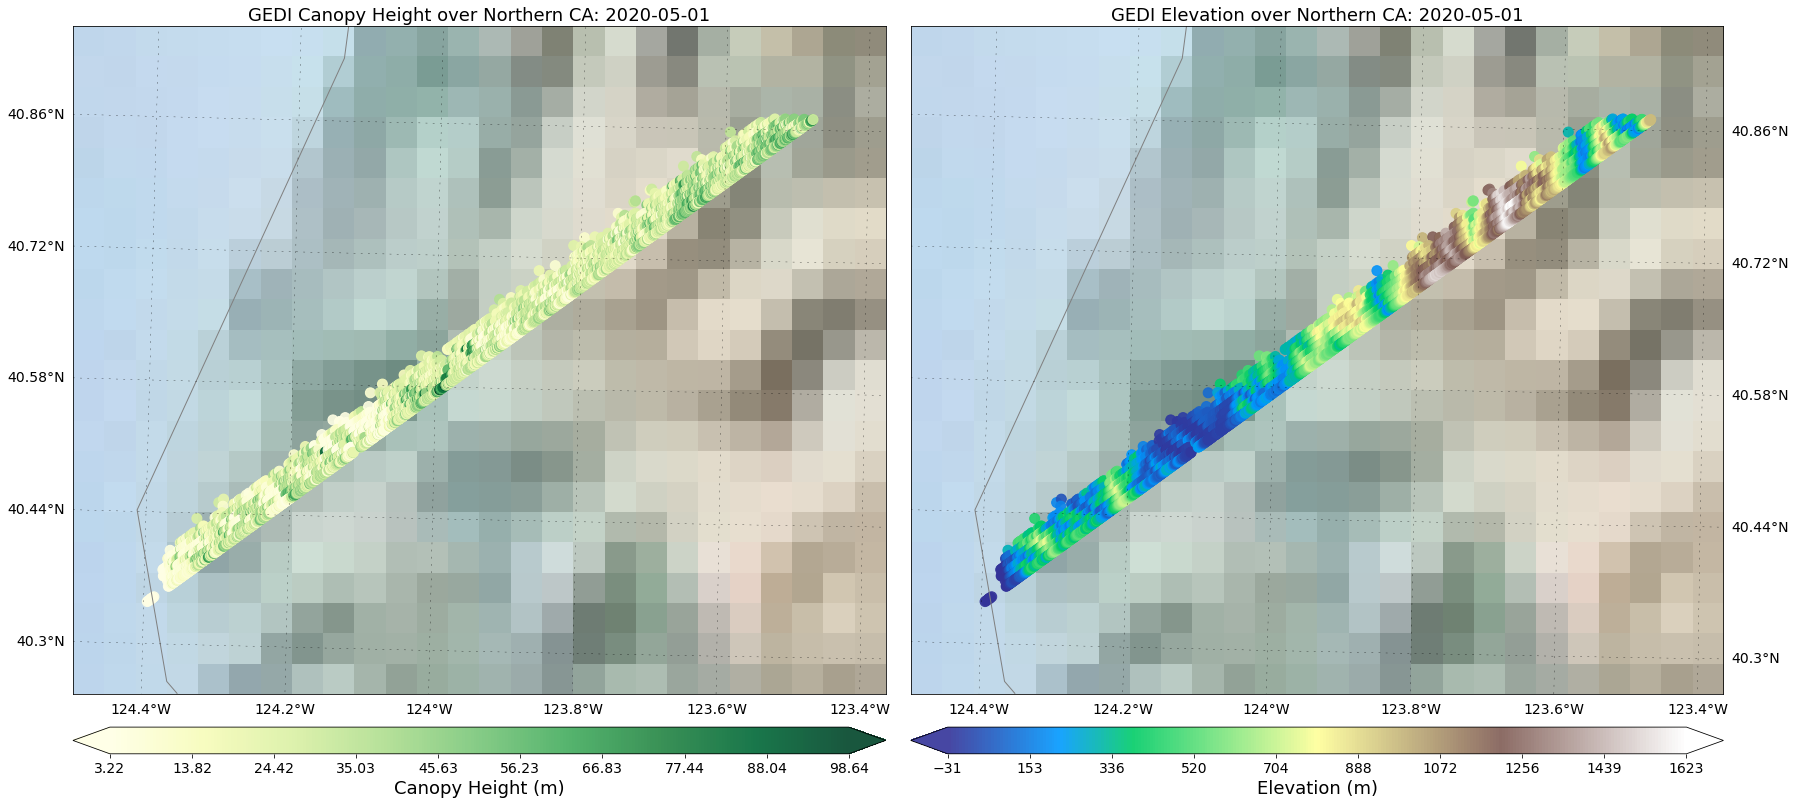

In [8]:
fig, axes = plt.subplots(1,2, figsize=(25,20))#(width,height)
axes = axes.ravel()
#fig.subplots_adjust(hspace=0.16, wspace=0)

lon = gdf['Longitude'].values
lat = gdf['Latitude'].values

for i, ax in enumerate(axes):
    m = Basemap(ax = axes[i],projection='lcc',resolution='l',llcrnrlon=min(lon)-0.1,llcrnrlat=min(lat)-0.1,\
                urcrnrlon=max(lon)+0.1,urcrnrlat=max(lat)+0.1,lat_1=39,lat_2=40,lon_0=-122,width=1E6, height=1.2E6)
    
    m.shadedrelief()
    m.drawcoastlines(color='gray')
    m.drawcountries(color='black')
    #m.drawstates(color='black')
    #m.drawlsmask(land_color='Linen', ocean_color='#CCFFFF')

    parallels = np.arange(20,50,0.14) # make latitude lines 
    meridians = np.arange(-130,-80,0.2) 
    
    if i == 0:
        title_name = 'GEDI Canopy Height over Northern CA: ' + yyyymmdd   
        data = gdf['Canopy Height (rh100)'].values
        c_map = 'YlGn'
        m.drawparallels(parallels,linewidth=0.3,labels=[1,0,0,0],fontsize=14,dashes=[6, 18])
        m.drawmeridians(meridians,linewidth=0.3,labels=[0,0,0,1],fontsize=14,dashes=[6, 18])
        label_bar = 'Canopy Height (m)'
        
    elif i == 1:
        title_name = 'GEDI Elevation over Northern CA: ' + yyyymmdd 
        data = gdf['Elevation (m)'].values
        c_map = 'terrain'
        m.drawparallels(parallels,linewidth=0.3,labels=[0,1,0,0],fontsize=14,dashes=[6, 18])
        m.drawmeridians(meridians,linewidth=0.3,labels=[0,0,0,1],fontsize=14,dashes=[6, 18])
        label_bar = 'Elevation (m)'
    

    im = m.scatter(lon, lat, latlon=True,c=data,s=100,cmap=plt.get_cmap(c_map), alpha=0.9)
    ax.set_title(title_name,fontsize=18) 
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("bottom", size="4%", pad="5%")
    ticks = np.linspace(min(data), max(data), 10)
    cb = fig.colorbar(im, ax=ax,extend='both', cax=cax, orientation="horizontal",ticks=ticks)
    cb.ax.tick_params(labelsize=14)
    cb.set_label(label=label_bar,fontsize=18)
    
plt.tight_layout()
plt.savefig('./output/fig_01_Canopy_Height_Elevation.png',dpi=100,bbox_inches='tight')
plt.show()

## Exporting Geopandas to Google Earth Engine (GEE) for Further Analysis

### Authenticate to Earth Engine

In [9]:
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AX4XfWg5ILxHJulHiZPKtREpxrAB00Q7MHpAf2EZResNJNOmh11D08k5If0



Successfully saved authorization token.


### Processing Geopandas from Multiple Days & Exporting to Asset in Google Earth Engine

In [10]:
%%time
for i in filenames_combined:
    gdf, lon_center, lat_center, yyyymmdd = gediHeight(i,filaname_geojson)
    gdf_mod = gdf.drop(['Shot Index','Latitude','Longitude'], axis=1)  
    
    fc = geemap.geopandas_to_ee(gdf_mod)
    
    asset_name = 'users/<uid>/fc_GEDI_for_Northern_CA_' + yyyymmdd 
    ## (where <uid> is your user name for Google without the brackets)
    
    task = ee.batch.Export.table.toAsset(**{
         'collection': fc,
         'description':'exportToTableAsset_of_featurecollection_from_GEDI',
         'assetId': asset_name
    })
    task.start()   

CPU times: user 2min 35s, sys: 30.1 s, total: 3min 5s
Wall time: 3min 46s
